C:\Users\Neethu\Desktop\Python\Quantinum
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246742 entries, 0 to 246741
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   LCardNumber  246742 non-null  int64         
 1   Date         246742 non-null  datetime64[ns]
 2   StoreNumber  246742 non-null  int64         
 3   TxnID        246742 non-null  category      
 4   ProdNumber   246742 non-null  category      
 5   ProdName     246742 non-null  object        
 6   ProdQuality  246742 non-null  int64         
 7   TotalSales   246742 non-null  float64       
 8   Lifestage    246742 non-null  object        
 9   PCustomer    246742 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 28.1+ MB


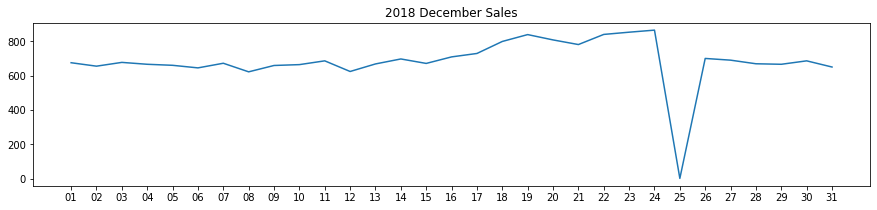

1.834645908180742e-237


True

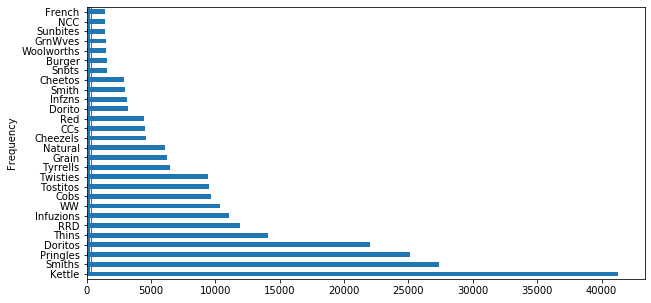

In [50]:
#importing required packages
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import re
import seaborn as sns
import plotly.express as px

from datetime import date

print(os.getcwd())


#importing two datasets
datab =pd.read_csv('QVI_purchase_behaviour.csv')

datat =pd.read_csv('QVI_transaction_data.csv')


#checking data
len(datab)
len(datat)

#checking coulmns names
datab.columns
datat.columns

#changing the column names
datab.columns=['LCardNumber','Lifestage','PCustomer']
datat.columns=['Date','StoreNumber','LCardNumber','TxnID','ProdNumber','ProdName','ProdQuality','TotalSales']

#Datatype of date was changed to Date in excel

#change datatype of date, ProdNumber,LCardNumber and TxnID
datat.Date =datat.Date.astype('datetime64')
datat.ProdNumber =datat.ProdNumber.astype('category')
datat.LCardNumber =datat.LCardNumber.astype('category')
datat.TxnID =datat.TxnID.astype('category')

#Products which are salsa are filtered and removed in excel
#merging two datasets
tdata=datat.set_index('LCardNumber').join(datab.set_index('LCardNumber'))
tdata=tdata.reset_index()
tdata=tdata.sort_values(by='Date').reset_index(drop='TRUE')

len(tdata)
tdata.columns
# to get info about the dataframe after merge

tdata.info()

#Products which are salsa are filtered and removed in excel
# spilt the weight from Product name and store in a new column Product weight
tdata['ProdWeight']=tdata['ProdName'].map(lambda x: float(''.join(re.findall(r'\d+', x))))

#to check the count of Product name
tdata['ProdName'].value_counts()

#to check all unique product names
tdata['ProdName'].unique()

#to find outliers 
tdata['ProdQuality'].value_counts(bins=4).sort_index()

tdata['ProdQuality'].sort_values(ascending=False).head()

#to remove the to outliers

tdata=tdata[tdata['ProdQuality'] < 6]


#validating if outliers are removed 
len(tdata[tdata["LCardNumber"] == 226000])

#to check if all 365 days are present in date
tdata['Date'].describe()

#to find the missing date
pd.date_range(start=tdata['Date'].min(), end=tdata['Date'].max()).difference(tdata['Date'])

#since its december 25th we can leave it moving to product



#to plot the graph dates
check_null_date = pd.merge(pd.Series(pd.date_range(start=tdata["Date"].min(), end=tdata["Date"].max()), name="Date"), tdata, on="Date", how="left")


trans_by_date = check_null_date["Date"].value_counts()
dec = trans_by_date[(trans_by_date.index >= pd.datetime(2018,12,1)) & (trans_by_date.index < pd.datetime(2019,1,1))].sort_index()
dec.index = dec.index.strftime('%d')
ax = dec.plot(figsize=(15,3))
ax.set_xticks(np.arange(len(dec)))
ax.set_xticklabels(dec.index)
plt.title("2018 December Sales")
plt.savefig("2018 December Sales.png", bbox_inches="tight")
plt.show()

#to plot histogram for product weights
tdata['ProdWeight'].describe()
tdata['ProdWeight'].plot.hist()

#exploring Brand names
#spliting the product names and counting the values of first name and sorting it 
tdata["ProdName"].str.split().str[0].value_counts().sort_index()
#transfer the first name of all products to a new column with clean brand names 
tdata["CleanBrandNames"] = tdata["ProdName"].str.split().str[0]

#function to clean brand names
def clean_names(line):
    brand = line["CleanBrandNames"]
    if brand == "Dorito":
        return "Doritos"
    elif brand == "GrnWves" or brand == "Grain":
        return "Grain Waves"
    elif brand == "Infzns":
        return "Infuzions"
    elif brand == "Natural" or brand == "NCC":
        return "Natural Chip Co"
    elif brand == "Red":
        return "RRD"
    elif brand == "Smith":
        return "Smiths"
    elif brand == "Snbts":
        return "Sunbites"
    elif brand == "WW":
        return "Woolworths"
    else:
        return brand

    tdata["CleanBrandNames"] = tdata.apply(lambda line: clean_names(line), axis=1)
tdata.head()
    
#bar graph to see the product counts
tdata['CleanBrandNames'].value_counts().plot.barh(figsize=(10,5))

#checking for null value
tdata.isnull().sum()

#saving the present data set for task 2 

#tdata.to_csv('Task1.csv')

#Data exploration is now complete!
## Data analysis on customer segments

##Now that the data is ready for analysis, we can define some metrics of interest to the client:
#- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
#- How many customers are in each segment
#- How many chips are bought per customer by segment
#- What's the average chip price by customer segment

#grouped_sales = pd.DataFrame(tdata.groupby(["Lifestage", "PCustomer"])["TotalSales"].agg(["sum", "mean"]))
#grouped_sales.sort_values(ascending=False, by="sum")

#to find proportion of sales
byc = tdata.groupby(['Lifestage','PCustomer'])[['TotalSales']].sum().reset_index()
byc
fig = px.bar(byc,byc['Lifestage'],byc['TotalSales'],byc['PCustomer'],text=(byc['TotalSales']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title='Proportion of Sales',title_x=0.5)

fig.show()
plt.savefig("Proportion of Sales.png", bbox_inches="tight")

#to find porportion of customers

byc1 = tdata.groupby(['Lifestage','PCustomer'])[['LCardNumber']].sum().reset_index()
byc1
fig = px.bar(byc1,byc1['Lifestage'],byc1['LCardNumber'],byc1['PCustomer'],text=(byc1['LCardNumber']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title='Proportion of Customers',title_x=0.5)

fig.show()
plt.savefig("Proportion of Customers.png", bbox_inches="tight")

#to find unique customers
uniquecust = tdata[tdata['LCardNumber'].isin(list(pd.unique(tdata['LCardNumber'])))].copy()
byc2 = uniquecust.groupby(['Lifestage','PCustomer'])[['ProdQuality','LCardNumber']].sum().reset_index()
byc2['AVG'] = byc2['ProdQuality'] / byc2['LCardNumber']

fig = px.bar(byc2,byc2['Lifestage'],byc2['AVG'],byc2['PCustomer'])
# Change the bar mode
fig.update_layout(barmode='group',title='Average Units per customer',title_x=0.5)
fig.show()
plt.savefig("AVG units per cstomer.png", bbox_inches="tight")


#to find stats
from scipy.stats import ttest_ind
tdata['PricePerUnit'] = tdata['TotalSales'] / tdata['ProdQuality']
f1 = tdata[(tdata['Lifestage'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))  & (tdata['PCustomer'] == 'Mainstream')]
f2 = tdata[(tdata['Lifestage'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))  & (tdata['PCustomer'] != 'Mainstream')]
f2

scipy.stats.ttest_ind(f1['PricePerUnit'],f2['PricePerUnit'])

#or stats

mainstream = tdata["PCustomer"] == "Mainstream"
young_midage = (tdata["Lifestage"] == "MIDAGE SINGLES/COUPLES") | (tdata["Lifestage"] == "YOUNG SINGLES/COUPLES")

budget_premium = (tdata["PCustomer"] == "Budget") | (tdata["PCustomer"] == "Premium")

a = tdata[young_midage & mainstream]["TotalSales"]
b = tdata[young_midage & budget_premium]["TotalSales"]
stat, pval = ttest_ind(a.values, b.values, equal_var=False)

print(pval)
pval < 0.0000001


In [12]:
len(tdata)

246742

In [7]:
tdata.columns

Index(['LCardNumber', 'Date', 'StoreNumber', 'TxnID', 'ProdNumber', 'ProdName',
       'ProdQuality', 'TotalSales', 'Lifestage', 'PCustomer'],
      dtype='object')

In [8]:
tdata.head(50)

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer
0,40076,1/1/2019,40,36473,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,MIDAGE SINGLES/COUPLES,Mainstream
1,58331,1/1/2019,58,54285,15,Twisties Cheese 270g,2,9.2,YOUNG FAMILIES,Budget
2,234341,1/1/2019,234,237786,40,Thins Chips Seasonedchicken 175g,1,3.3,OLDER SINGLES/COUPLES,Mainstream
3,13121,1/1/2019,13,11848,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,OLDER FAMILIES,Mainstream
4,118028,1/1/2019,118,120839,1,Smiths Crinkle Cut Chips Barbecue 170g,2,5.8,MIDAGE SINGLES/COUPLES,Budget
5,208226,1/1/2019,208,207446,81,Pringles Original Crisps 134g,2,7.4,OLDER FAMILIES,Mainstream
6,209004,1/1/2019,209,207511,22,Thins Chips Originl saltd 175g,2,6.6,MIDAGE SINGLES/COUPLES,Premium
7,209004,1/1/2019,209,207511,17,Kettle Sensations BBQ&Maple 150g,2,9.2,MIDAGE SINGLES/COUPLES,Premium
8,118081,1/1/2019,118,121143,37,Smiths Thinly Swt Chli&S/Cream175G,2,6.0,MIDAGE SINGLES/COUPLES,Premium
9,234121,1/1/2019,234,237467,36,Kettle Chilli 175g,2,10.8,YOUNG FAMILIES,Mainstream


In [13]:
tdata.tail(50)

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer
264786,165189,2019-06-30,165,166262,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,OLDER SINGLES/COUPLES,Premium
264787,80151,2019-06-30,80,78870,3,Kettle Sensations Camembert & Fig 150g,2,9.2,OLDER SINGLES/COUPLES,Mainstream
264788,113010,2019-06-30,113,115422,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,OLDER FAMILIES,Mainstream
264789,72092,2019-06-30,72,70989,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8,OLDER FAMILIES,Budget
264790,5025,2019-06-30,5,4523,78,Thins Chips Salt & Vinegar 175g,2,6.6,YOUNG FAMILIES,Premium
264791,200016,2019-06-30,200,199293,50,Tostitos Lightly Salted 175g,2,8.8,OLDER SINGLES/COUPLES,Budget
264792,151435,2019-06-30,151,150131,109,Pringles Barbeque 134g,1,3.7,YOUNG SINGLES/COUPLES,Mainstream
264793,25112,2019-06-30,25,21830,112,Tyrrells Crisps Ched & Chives 165g,2,8.4,NEW FAMILIES,Premium
264794,122030,2019-06-30,122,124843,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,OLDER FAMILIES,Budget
264795,65055,2019-06-30,65,61905,75,Cobs Popd Sea Salt Chips 110g,2,7.6,RETIREES,Budget


In [11]:
tdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246742 entries, 0 to 246741
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   LCardNumber  246742 non-null  int64   
 1   Date         246742 non-null  category
 2   StoreNumber  246742 non-null  int64   
 3   TxnID        246742 non-null  category
 4   ProdNumber   246742 non-null  category
 5   ProdName     246742 non-null  object  
 6   ProdQuality  246742 non-null  int64   
 7   TotalSales   246742 non-null  float64 
 8   Lifestage    246742 non-null  object  
 9   PCustomer    246742 non-null  object  
dtypes: category(3), float64(1), int64(3), object(3)
memory usage: 26.7+ MB


In [14]:
#tdata['ProdName'].value_counts()
tdata['ProdName'].unique()

array(['Smiths Crnkle Chip  Orgnl Big Bag 380g',
       'Twisties Cheese     270g', 'Thins Chips Seasonedchicken 175g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Smiths Crinkle Cut  Chips Barbecue 170g',
       'Pringles Original   Crisps 134g',
       'Thins Chips         Originl saltd 175g',
       'Kettle Sensations   BBQ&Maple 150g',
       'Smiths Thinly       Swt Chli&S/Cream175G', 'Kettle Chilli 175g',
       'Grain Waves         Sweet Chilli 210g',
       'Pringles Barbeque   134g', 'Pringles SourCream  Onion 134g',
       'WW Sour Cream &OnionStacked Chips 160g',
       'RRD SR Slow Rst     Pork Belly 150g',
       'WW Crinkle Cut      Chicken 175g',
       'Kettle Sensations   Siracha Lime 150g',
       'Kettle Mozzarella   Basil & Pesto 175g',
       'French Fries Potato Chips 175g',
       'Smiths Chip Thinly  Cut Original 175g',
       'Cobs Popd Sour Crm  &Chives Chips 110g',
       'Thins Chips Salt &  Vinegar 175g',
       'Doritos Cheese      Supreme 33

In [19]:
# chips=tdata[tdata['ProdName'].str.contains('Salsa') == 'FALSE'].copy()
tdata['ProdWeight']=tdata['ProdName'].map(lambda x: float(''.join(re.findall(r'\d+', x))))
#split_prods = tdata["ProdName"].str.replace(r'([0-9]+[gG])','').str.replace(r'[^\w]', ' ').str.split()

In [22]:
tdata
#split_prods

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer,ProdWeight
0,40076,1/1/2019,40,36473,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,MIDAGE SINGLES/COUPLES,Mainstream,380.0
1,58331,1/1/2019,58,54285,15,Twisties Cheese 270g,2,9.2,YOUNG FAMILIES,Budget,270.0
2,234341,1/1/2019,234,237786,40,Thins Chips Seasonedchicken 175g,1,3.3,OLDER SINGLES/COUPLES,Mainstream,175.0
3,13121,1/1/2019,13,11848,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,OLDER FAMILIES,Mainstream,150.0
4,118028,1/1/2019,118,120839,1,Smiths Crinkle Cut Chips Barbecue 170g,2,5.8,MIDAGE SINGLES/COUPLES,Budget,170.0
...,...,...,...,...,...,...,...,...,...,...,...
246737,54113,9/9/2018,54,47995,99,Pringles Sthrn FriedChicken 134g,2,7.4,YOUNG SINGLES/COUPLES,Budget,134.0
246738,40047,9/9/2018,40,36328,62,Pringles Mystery Flavour 134g,2,7.4,RETIREES,Premium,134.0
246739,94199,9/9/2018,94,93742,85,RRD Honey Soy Chicken 165g,2,6.0,MIDAGE SINGLES/COUPLES,Budget,165.0
246740,188096,9/9/2018,188,189421,46,Kettle Original 175g,2,10.8,YOUNG FAMILIES,Budget,175.0


In [23]:
tdata['ProdQuality'].value_counts(bins=4).sort_index()

(0.8, 50.75]       246740
(50.75, 100.5]          0
(100.5, 150.25]         0
(150.25, 200.0]         2
Name: ProdQuality, dtype: int64

In [24]:
tdata['ProdQuality'].sort_values(ascending=False).head()

212723    200
151495    200
147039      5
147430      5
151961      5
Name: ProdQuality, dtype: int64

In [26]:
tdata=tdata[tdata['ProdQuality'] < 6]

In [27]:
tdata

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer,ProdWeight
0,40076,1/1/2019,40,36473,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,MIDAGE SINGLES/COUPLES,Mainstream,380.0
1,58331,1/1/2019,58,54285,15,Twisties Cheese 270g,2,9.2,YOUNG FAMILIES,Budget,270.0
2,234341,1/1/2019,234,237786,40,Thins Chips Seasonedchicken 175g,1,3.3,OLDER SINGLES/COUPLES,Mainstream,175.0
3,13121,1/1/2019,13,11848,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,OLDER FAMILIES,Mainstream,150.0
4,118028,1/1/2019,118,120839,1,Smiths Crinkle Cut Chips Barbecue 170g,2,5.8,MIDAGE SINGLES/COUPLES,Budget,170.0
...,...,...,...,...,...,...,...,...,...,...,...
246737,54113,9/9/2018,54,47995,99,Pringles Sthrn FriedChicken 134g,2,7.4,YOUNG SINGLES/COUPLES,Budget,134.0
246738,40047,9/9/2018,40,36328,62,Pringles Mystery Flavour 134g,2,7.4,RETIREES,Premium,134.0
246739,94199,9/9/2018,94,93742,85,RRD Honey Soy Chicken 165g,2,6.0,MIDAGE SINGLES/COUPLES,Budget,165.0
246740,188096,9/9/2018,188,189421,46,Kettle Original 175g,2,10.8,YOUNG FAMILIES,Budget,175.0


In [28]:
len(tdata[tdata["LCardNumber"] == 226000])

0

In [29]:
tdata['Date'].describe()

count         246740
unique           364
top       12/24/2018
freq             865
Name: Date, dtype: object

In [32]:
pd.date_range(start=tdata['Date'].min(), end=tdata['Date'].max()).difference(tdata['Date'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [61]:

check_null_date = pd.merge(pd.Series(pd.date_range(start=tdata["Date"].min(), end=tdata["Date"].max()), name="Date"), tdata, on="Date", how="left")


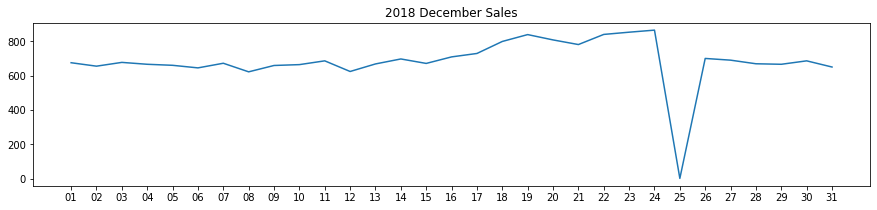

In [62]:
trans_by_date = check_null_date["Date"].value_counts()
dec = trans_by_date[(trans_by_date.index >= pd.datetime(2018,12,1)) & (trans_by_date.index < pd.datetime(2019,1,1))].sort_index()
dec.index = dec.index.strftime('%d')
ax = dec.plot(figsize=(15,3))
ax.set_xticks(np.arange(len(dec)))
ax.set_xticklabels(dec.index)
plt.title("2018 December Sales")
plt.savefig("2018 December Sales.png", bbox_inches="tight")
plt.show()

In [34]:
tdata.ProdWeight

0         330.0
1         134.0
2         170.0
3         134.0
4         175.0
          ...  
246737    190.0
246738    330.0
246739    330.0
246740    150.0
246741    175.0
Name: ProdWeight, Length: 246740, dtype: float64

In [35]:
tdata['ProdWeight'].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: ProdWeight, dtype: float64

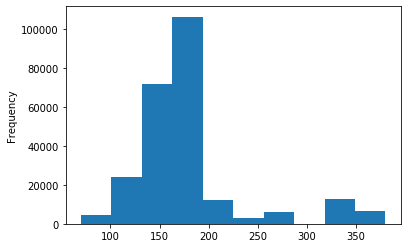

In [37]:
tdata['ProdWeight'].plot.hist()

In [39]:
tdata["ProdName"].str.split().str[0].value_counts().sort_index()

Burger         1564
CCs            4551
Cheetos        2927
Cheezels       4603
Cobs           9693
Dorito         3183
Doritos       22041
French         1418
Grain          6272
GrnWves        1468
Infuzions     11057
Infzns         3144
Kettle        41288
NCC            1419
Natural        6050
Pringles      25102
RRD           11894
Red            4427
Smith          2963
Smiths        27390
Snbts          1576
Sunbites       1432
Thins         14075
Tostitos       9471
Twisties       9454
Tyrrells       6442
WW            10320
Woolworths     1516
Name: ProdName, dtype: int64

In [40]:
tdata["CleanBrandNames"] = tdata["ProdName"].str.split().str[0]

In [41]:
tdata.head()

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer,ProdWeight,CleanBrandNames
0,207165,2018-07-01,207,205566,16,Smiths Crinkle Chips Salt & Vinegar 330g,2,11.4,MIDAGE SINGLES/COUPLES,Mainstream,330.0,Smiths
1,58195,2018-07-01,58,53678,26,Pringles Sweet&Spcy BBQ 134g,2,7.4,MIDAGE SINGLES/COUPLES,Mainstream,134.0,Pringles
2,58201,2018-07-01,58,53702,47,Doritos Corn Chips Original 170g,2,8.8,RETIREES,Budget,170.0,Doritos
3,58242,2018-07-01,58,53871,62,Pringles Mystery Flavour 134g,2,7.4,OLDER SINGLES/COUPLES,Mainstream,134.0,Pringles
4,207184,2018-07-01,207,205693,32,Kettle Sea Salt And Vinegar 175g,2,10.8,RETIREES,Premium,175.0,Kettle


In [42]:
def clean_names(line):
    brand = line["CleanBrandNames"]
    if brand == "Dorito":
        return "Doritos"
    elif brand == "GrnWves" or brand == "Grain":
        return "Grain Waves"
    elif brand == "Infzns":
        return "Infuzions"
    elif brand == "Natural" or brand == "NCC":
        return "Natural Chip Co"
    elif brand == "Red":
        return "RRD"
    elif brand == "Smith":
        return "Smiths"
    elif brand == "Snbts":
        return "Sunbites"
    elif brand == "WW":
        return "Woolworths"
    else:
        return brand

In [43]:
tdata["CleanBrandNames"] = tdata.apply(lambda line: clean_names(line), axis=1)

In [44]:
tdata.head()

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer,ProdWeight,CleanBrandNames
0,207165,2018-07-01,207,205566,16,Smiths Crinkle Chips Salt & Vinegar 330g,2,11.4,MIDAGE SINGLES/COUPLES,Mainstream,330.0,Smiths
1,58195,2018-07-01,58,53678,26,Pringles Sweet&Spcy BBQ 134g,2,7.4,MIDAGE SINGLES/COUPLES,Mainstream,134.0,Pringles
2,58201,2018-07-01,58,53702,47,Doritos Corn Chips Original 170g,2,8.8,RETIREES,Budget,170.0,Doritos
3,58242,2018-07-01,58,53871,62,Pringles Mystery Flavour 134g,2,7.4,OLDER SINGLES/COUPLES,Mainstream,134.0,Pringles
4,207184,2018-07-01,207,205693,32,Kettle Sea Salt And Vinegar 175g,2,10.8,RETIREES,Premium,175.0,Kettle


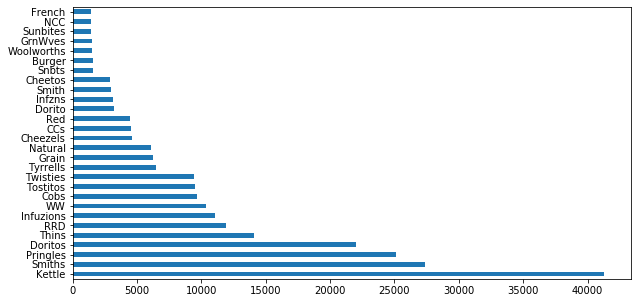

In [68]:
tdata['CleanBrandNames'].value_counts().plot.barh(figsize=(10,5))

In [59]:
tdata.isnull().sum()

LCardNumber        0
Date               0
StoreNumber        0
TxnID              0
ProdNumber         0
ProdName           0
ProdQuality        0
TotalSales         0
Lifestage          0
PCustomer          0
ProdWeight         0
CleanBrandNames    0
dtype: int64

In [63]:
tdata.to_csv('Task1.csv')

In [64]:
grouped_sales = pd.DataFrame(tdata.groupby(["Lifestage", "PCustomer"])["TotalSales"].agg(["sum", "mean"]))
grouped_sales.sort_values(ascending=False, by="sum")

sum      mean
Lifestage              PCustomer                      
OLDER FAMILIES         Budget      156863.75  7.291241
YOUNG SINGLES/COUPLES  Mainstream  147582.20  7.551279
RETIREES               Mainstream  145168.95  7.269352
YOUNG FAMILIES         Budget      129717.95  7.302705
OLDER SINGLES/COUPLES  Budget      127833.60  7.444305
                       Mainstream  124648.50  7.306049
                       Premium     123537.55  7.459997
RETIREES               Budget      105916.30  7.445786
OLDER FAMILIES         Mainstream   96413.55  7.281440
RETIREES               Premium      91296.65  7.461315
YOUNG FAMILIES         Mainstream   86338.25  7.226772
MIDAGE SINGLES/COUPLES Mainstream   84734.25  7.637156
YOUNG FAMILIES         Premium      78571.70  7.285951
OLDER FAMILIES         Premium      75242.60  7.232779
YOUNG SINGLES/COUPLES  Budget       57122.10  6.663023
MIDAGE SINGLES/COUPLES Premium      54443.85  7.152371
YOUNG SINGLES/COUPLES  Premium      39052.30  6.673325
MIDAGE SINGLES/COUPLES Budget       33345.70  7.108442
NEW FAMILIES           Budget       20607.45  7.297256
                       Mainstream   15979.70  7.313364
                       Premium      10760.80  7.231720

In [4]:
grouped_sales['sum'].sum()

1805177.6999999997

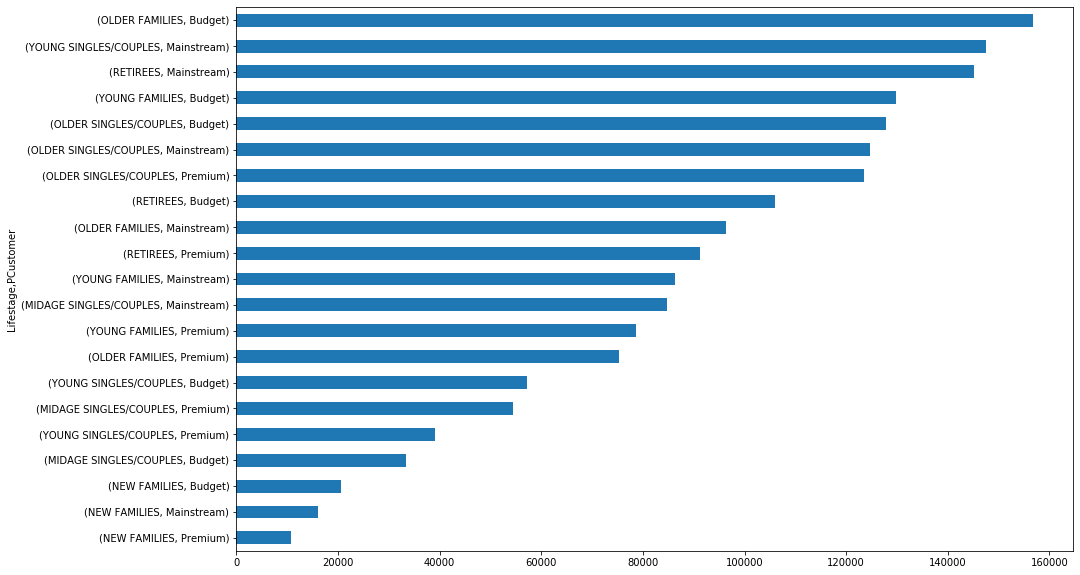

In [29]:
grouped_sales['sum'].sort_values().plot.barh(figsize=(15,10))

In [32]:
byc = tdata.groupby(['Lifestage','PCustomer'])[['TotalSales']].sum().reset_index()
byc

,Lifestage,PCustomer,TotalSales
0,MIDAGE SINGLES/COUPLES,Budget,33345.70
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25
2,MIDAGE SINGLES/COUPLES,Premium,54443.85
3,NEW FAMILIES,Budget,20607.45
4,NEW FAMILIES,Mainstream,15979.70
5,NEW FAMILIES,Premium,10760.80
6,OLDER FAMILIES,Budget,156863.75
7,OLDER FAMILIES,Mainstream,96413.55
8,OLDER FAMILIES,Premium,75242.60
9,OLDER SINGLES/COUPLES,Budget,127833.60


In [34]:
fig = px.bar(byc,byc['Lifestage'],byc['TotalSales'],byc['PCustomer'],text=(byc['TotalSales']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title='Proportion of Sales',title_x=0.5)

fig.show()
plt.savefig("Proportion of Sales.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [36]:
byc1 = tdata.groupby(['Lifestage','PCustomer'])[['LCardNumber']].sum().reset_index()
byc1
fig = px.bar(byc1,byc1['Lifestage'],byc1['LCardNumber'],byc1['PCustomer'],text=(byc1['LCardNumber']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title='Proportion of Customers',title_x=0.5)

fig.show()
plt.savefig("Proportion of Customers.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [39]:
uniquecust = tdata[tdata['LCardNumber'].isin(list(pd.unique(tdata['LCardNumber'])))].copy()
byc2 = uniquecust.groupby(['Lifestage','PCustomer'])[['ProdQuality','LCardNumber']].sum().reset_index()
byc2['AVG'] = byc2['ProdQuality'] / byc2['LCardNumber']

fig = px.bar(byc2,byc2['Lifestage'],byc2['AVG'],byc2['PCustomer'])
# Change the bar mode
fig.update_layout(barmode='group',title='AVG Units per customer',title_x=0.5)
fig.show()
plt.savefig("AVG units per cstomer.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [42]:
byc3 = tdata.groupby(['Lifestage','PCustomer'])[['TotalSales','ProdQuality']].sum().reset_index()
byc3['AVG'] = byc3['TotalSales'] / byc3['ProdQuality']

fig = px.bar(byc3,byc3['Lifestage'],byc3['AVG'],byc3['PCustomer'])
fig.update_layout(barmode='group',title='AVG Sales per Unit',title_x=0.5)
fig.show()
plt.savefig("AVG Sales per unit.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [47]:
from scipy.stats import ttest_ind
tdata['PricePerUnit'] = tdata['TotalSales'] / tdata['ProdQuality']
f1 = tdata[(tdata['Lifestage'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))  & (tdata['PCustomer'] == 'Mainstream')]
f2 = tdata[(tdata['Lifestage'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]))  & (tdata['PCustomer'] != 'Mainstream')]
f2

,LCardNumber,Date,StoreNumber,TxnID,ProdNumber,ProdName,ProdQuality,TotalSales,Lifestage,PCustomer,ProdWeight,CleanBrandNames,PricePerUnit
5,58351,2018-07-01,58,54374,102,Kettle Mozzarella Basil & Pesto 175g,2,10.8,MIDAGE SINGLES/COUPLES,Budget,175.0,Kettle,5.4
9,205430,2018-07-01,205,204503,37,Smiths Thinly Swt Chli&S/Cream175G,1,3.0,YOUNG SINGLES/COUPLES,Premium,175.0,Smiths,3.0
24,133198,2018-07-01,133,137307,107,Smiths Crinkle Cut French OnionDip 150g,2,5.2,MIDAGE SINGLES/COUPLES,Budget,150.0,Smiths,2.6
31,55073,2018-07-01,55,48884,91,CCs Tasty Cheese 175g,2,4.2,MIDAGE SINGLES/COUPLES,Budget,175.0,CCs,2.1
47,57147,2018-07-01,57,52098,81,Pringles Original Crisps 134g,2,7.4,YOUNG SINGLES/COUPLES,Budget,134.0,Pringles,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246720,80320,2019-06-30,80,79523,68,Pringles Chicken Salt Crips 134g,2,7.4,YOUNG SINGLES/COUPLES,Budget,134.0,Pringles,3.7
246723,244213,2019-06-30,244,247339,93,Doritos Corn Chip Southern Chicken 150g,2,7.8,YOUNG SINGLES/COUPLES,Premium,150.0,Doritos,3.9
246726,13245,2019-06-30,13,12671,95,Sunbites Whlegrn Crisps Frch/Onin 90g,2,3.4,MIDAGE SINGLES/COUPLES,Premium,90.0,Sunbites,1.7
246729,6258,2019-06-30,6,6047,29,French Fries Potato Chips 175g,1,3.0,YOUNG SINGLES/COUPLES,Budget,175.0,French,3.0


In [48]:
scipy.stats.ttest_ind(f1['PricePerUnit'],f2['PricePerUnit'])

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

In [49]:
mainstream = tdata["PCustomer"] == "Mainstream"
young_midage = (tdata["Lifestage"] == "MIDAGE SINGLES/COUPLES") | (tdata["Lifestage"] == "YOUNG SINGLES/COUPLES")

budget_premium = (tdata["PCustomer"] == "Budget") | (tdata["PCustomer"] == "Premium")

a = tdata[young_midage & mainstream]["TotalSales"]
b = tdata[young_midage & budget_premium]["TotalSales"]
stat, pval = ttest_ind(a.values, b.values, equal_var=False)

print(pval)
pval < 0.0000001

1.834645908180742e-237


True